In [46]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np 
import pandas as pd

In [48]:
dataset_path = "./dataset.csv"
full = True

df = pd.read_csv(
    dataset_path,
    # dtype is specified to prevent a DtypeWarning
    dtype={
        "full_query": str,
        "label": int,
        "statement_type": str,
        "query_template_id": str,
        "attack_payload": str,
        "attack_id": str,
        "attack_technique": str,
        "attack_desc": str,
        "split": str,
        "sqlmap_status" : str,
        "attack_stage" : str,
    },
)


/tmp/nix-shell-2503-0/ipykernel_24377/2024024300.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


## Generic stats   


In [49]:
def display_counts_recon(df : pd.DataFrame):
    result = df.groupby('attack_id')['attack_stage'].value_counts().unstack(fill_value=0)
    
    if full:
        with pd.option_context('display.max_rows', None, 
                        'display.max_columns', None,
                        'display.width', None,
                        'display.max_colwidth', None):
            display(result)
    else: 
        display(result)

        
_ = display_counts_recon(df)


attack_stage,exploit,recon
attack_id,,
boolean-0,0,323
boolean-103,0,63
boolean-109,21,151
boolean-115,10,251
boolean-12,611,460
boolean-121,6323,153
boolean-127,631,10
boolean-133,1973,485
boolean-139,6,100


In [50]:
def display_attack_normal_per_set(df : pd.DataFrame):
    df_train_atk = df[(df["label"] == 1) & (df["split"] == "train")]  
    df_train_normal = df[(df["label"] == 0) & (df["split"] == "train")]  

    df_test_atk = df[(df["label"] == 1) & (df["split"] == "test")]  
    df_test_normal = df[(df["label"] == 0) & (df["split"] == "test")]  

    print(f"Number of attacks in train: {df_train_atk.shape[0]}")
    print(f"Number of normal in train: {df_train_normal.shape[0]}")
    print(f"Number of attacks in test: {df_test_atk.shape[0]}")
    print(f"Number of normal in test: {df_test_normal.shape[0]}")

display_attack_normal_per_set(df)

Number of attacks in train: 106756
Number of normal in train: 94237
Number of attacks in test: 73838
Number of normal in test: 811601


In [51]:
def display_ids_per_set(df: pd.DataFrame):
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]

    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    tids_complement = set(tids_test) - set(tids_train)
    print(f"Template IDS in df train: {len(tids_train)}, {tids_train}")
    print(f"Template IDS in df test:   {len(tids_test)}, {tids_test}")
    print(
        f"Template IDs in test but NOT in train: {len(tids_complement)}, {tids_complement}"
    )

    # Compute which template only have normal queries
    df_n = df.loc[df["label"] == 0,"query_template_id"].unique()
    df_a = df.loc[df["label"] == 1,"query_template_id"].unique()

    print(f"Templates IDs with no attacks: {set(df_n) - set(df_a)}")


display_ids_per_set(df)

Template IDS in df train: 39, ['airport-S23' 'airport-D8' 'airport-S11' 'airport-S22' 'airport-U8'
 'airport-S6' 'airport-I2' 'airport-S9' 'airport-S8' 'airport-U2'
 'airport-S17' 'airport-S12' 'airport-I10' 'airport-D2' 'airport-I6'
 'airport-I9' 'airport-D5' 'airport-D1' 'airport-U3' 'airport-S19'
 'airport-D6' 'airport-S16' 'airport-I8' 'airport-U6' 'airport-S13'
 'airport-admin5' 'airport-admin8' 'airport-admin6' 'airport-admin3'
 'airport-admin4' 'airport-admin11' 'airport-admin14' 'airport-admin9'
 'airport-admin2' 'airport-admin13' 'airport-admin1' 'airport-admin10'
 'airport-admin7' 'airport-admin12']
Template IDS in df test:   58, ['airport-I2' 'airport-D7' 'airport-S4' 'airport-S16' 'airport-S21'
 'airport-S9' 'airport-I7' 'airport-S17' 'airport-D8' 'airport-I8'
 'airport-S18' 'airport-U7' 'airport-I1' 'airport-S14' 'airport-U8'
 'airport-S15' 'airport-U9' 'airport-S6' 'airport-S1' 'airport-S11'
 'airport-D2' 'airport-I9' 'airport-S10' 'airport-S2' 'airport-D6'
 'airport-S8' 

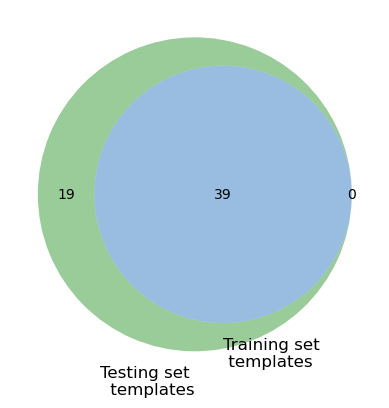

In [52]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_templates_in_sets(df : pd.DataFrame): 
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    
    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    venn2((set(tids_test),set(tids_train)), ("Testing set \n templates","Training set \n templates"),set_colors=("green","blue"))
    plt.show()

plot_templates_in_sets(df=df)

In [53]:
def _stmt_proportion(df: pd.DataFrame):
    return df['statement_type'].value_counts(normalize=True)

def display_ratio_per_stmt(df : pd.DataFrame):
    
    df_a = df[df["label"] == 1]
    df_n = df[df["label"] == 0]
    print(f"Proportion amongst normal: {_stmt_proportion(df=df_n)}")
    print(f"Proportion amongst attacks: {_stmt_proportion(df=df_a)}")
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    print(f"Proportion amongst train: {_stmt_proportion(df=df_train)}")
    print(f"Proportion amongst test: {_stmt_proportion(df=df_test)}")

    dfntest = df_test[df_test["label"] == 0]

display_ratio_per_stmt(df=df)

Proportion amongst normal: statement_type
select    0.697167
insert    0.101506
update    0.097698
delete    0.092914
admin     0.010715
Name: proportion, dtype: float64
Proportion amongst attacks: statement_type
select    0.392859
insert    0.320603
update    0.151179
delete    0.135359
Name: proportion, dtype: float64
Proportion amongst train: statement_type
select    0.499336
insert    0.241262
delete    0.137691
update    0.113074
admin     0.008637
Name: proportion, dtype: float64
Proportion amongst test: statement_type
select    0.680007
insert    0.114469
update    0.105116
delete    0.091407
admin     0.009001
Name: proportion, dtype: float64


In [54]:
def print_stats_original(df : pd.DataFrame):
    df_og = df[df["template_split"] == "original"]
    df_chall = df[df["template_split"] == "challenging"]

    tids_og = df_og["query_template_id"].unique()
    tids_chall = df_chall["query_template_id"].unique()
    print(f"Template IDS in df original: {len(tids_og)}, {tids_og}")
    print(f"Template IDS in df challenging:   {len(tids_chall)}, {tids_chall}")
    
    print(f"Queries in original set: {len(df_og)}")
    df_a = df_og[df_og["label"] == 1]
    df_n = df_og[df_og["label"] == 0]
    print(f"Number of attacks in original: {df_a.shape[0]}")
    print(f"Number of normal in original: {df_n.shape[0]}")

    print(f"Queries in challenging set: {len(df_chall)}")
    df_a = df_chall[df_chall["label"] == 1]
    df_n = df_chall[df_chall["label"] == 0]
    print(f"Number of attacks in challenging: {df_a.shape[0]}")
    print(f"Number of normal in challenging: {df_n.shape[0]}")
print_stats_original(df=df)

Template IDS in df original: 39, ['airport-I2' 'airport-S16' 'airport-S9' 'airport-S17' 'airport-D8'
 'airport-I8' 'airport-U8' 'airport-S6' 'airport-S11' 'airport-D2'
 'airport-I9' 'airport-D6' 'airport-S8' 'airport-U2' 'airport-S12'
 'airport-S13' 'airport-S23' 'airport-I6' 'airport-S19' 'airport-D5'
 'airport-I10' 'airport-S22' 'airport-U6' 'airport-D1' 'airport-admin13'
 'airport-U3' 'airport-admin5' 'airport-admin3' 'airport-admin11'
 'airport-admin14' 'airport-admin7' 'airport-admin9' 'airport-admin1'
 'airport-admin8' 'airport-admin6' 'airport-admin10' 'airport-admin2'
 'airport-admin12' 'airport-admin4']
Template IDS in df challenging:   19, ['airport-D7' 'airport-S4' 'airport-S21' 'airport-I7' 'airport-S18'
 'airport-U7' 'airport-I1' 'airport-S14' 'airport-S15' 'airport-U9'
 'airport-S1' 'airport-S10' 'airport-S2' 'airport-I4' 'airport-S7'
 'airport-S20' 'airport-U4' 'airport-U1' 'airport-D4']
Queries in original set: 692032
Number of attacks in original: 152657
Number of norm